In [55]:
# Лабораторная работа 1
# Отхонов Баир КТбо3-8
# Бакухин Александр КТбо3-8
# 24.09.2022

In [56]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [57]:
# Класс для хранения признаков
# name - название признака
# values - значения признака
# k - коэффициент корреляции Пирсона к цене
class Property:
   def __init__(self, name, values):
      self.name = name
      self.values = values
   name = ""
   values = []
   k = 0

# Инициализация значений
propertyList = []
K_VALUE = 0.62

In [58]:
# Функция для подсчета cредней квадратичной ошибки
def rmsle(y_true, y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [59]:
# Функция для парсинга данных из файла data_description.txt
def read_file():
   with open("data_description.txt", "r") as f:
      for line in f.readlines():
         isName = False
         isValues = False

         if line.startswith("\n") or line.startswith("\t"):
            continue
         elif line.startswith(' '):
            isValues = True
         else:
            isName = True

         if isName == True:
            for word in line.split(':'):
               propertyList.append(Property(word, []))
               break
            continue
         elif isValues == True:
            cnt = 0
            for i in line:
               cnt += 1
               if i != ' ':
                  word = line[cnt - 1: line.find('\t')]
                  break
            propertyList[len(propertyList) - 1].values.append(word)

In [60]:
# Функция для преобразования строк в числа в DataFrame
def df_string_to_number(df):
   dfCopy = df.copy(deep=True)

   for column in dfCopy.columns.values.tolist():
      for property in propertyList:
         if column == property.name:
            for i in range(len(property.values)):
               dfCopy[column] = dfCopy[column].replace([property.values[i]], int(len(property.values) - i))
            break

      # Зануляем пустые значения
      dfCopy[column] = dfCopy[column].replace(np.nan, 0)

      # Зануляем строки, которых нет в параметрах
      for value in dfCopy[column]:
         if type(value) is str:
            dfCopy[column] = dfCopy[column].replace([value], 0)

   return dfCopy

In [61]:
# Функция для удаления похожих признаков в DataFrame
def df_corr_delete_columns(x, corr_val):
   corr_matrix = x.corr()
   iters = range(len(corr_matrix.columns) - 1)
   drop_cols = []

   for i in iters:
      for j in range(i):
         item = corr_matrix.iloc[j:(j + 1), (i + 1):(i + 2)]
         col = item.columns
         row = item.index
         val = item.values
         if abs(val) >= corr_val:
            print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
            drop_cols.append(i)

   drops = sorted(set(drop_cols))[::-1]

   for i in drops:
      col = x.iloc[:, (i + 1):(i + 2)].columns.values
      x = x.drop(col, axis=1)

   return x

In [62]:
# Чтение файла
read_file()

In [63]:
# Считываем данные как dataframe
dfTrain = pd.read_csv('./train.csv')
dfTrainCopy = df_string_to_number(dfTrain)
dfTrainCopy = df_corr_delete_columns(dfTrainCopy, 0.8)
dfTrainCopy['SalePrice'] = dfTrain['SalePrice']
dfTrainCopy.to_csv('result_1.csv', index=False)

1stFlrSF | TotalBsmtSF | 0.82
TotRmsAbvGrd | GrLivArea | 0.83
GarageQual | GarageYrBlt | 0.97
GarageCond | GarageYrBlt | 0.97


In [64]:
# Получаем коэффициенты корреляции
chooseProperty = []
dataCorr = dfTrainCopy.corr()['SalePrice'].sort_values(ascending=False)
for item in dataCorr.index:
  for property in propertyList:
     if item == property.name:
        property.k = dataCorr[property.name]
        if property.k >= K_VALUE or property.k <= -K_VALUE:
           chooseProperty.append(property.name)

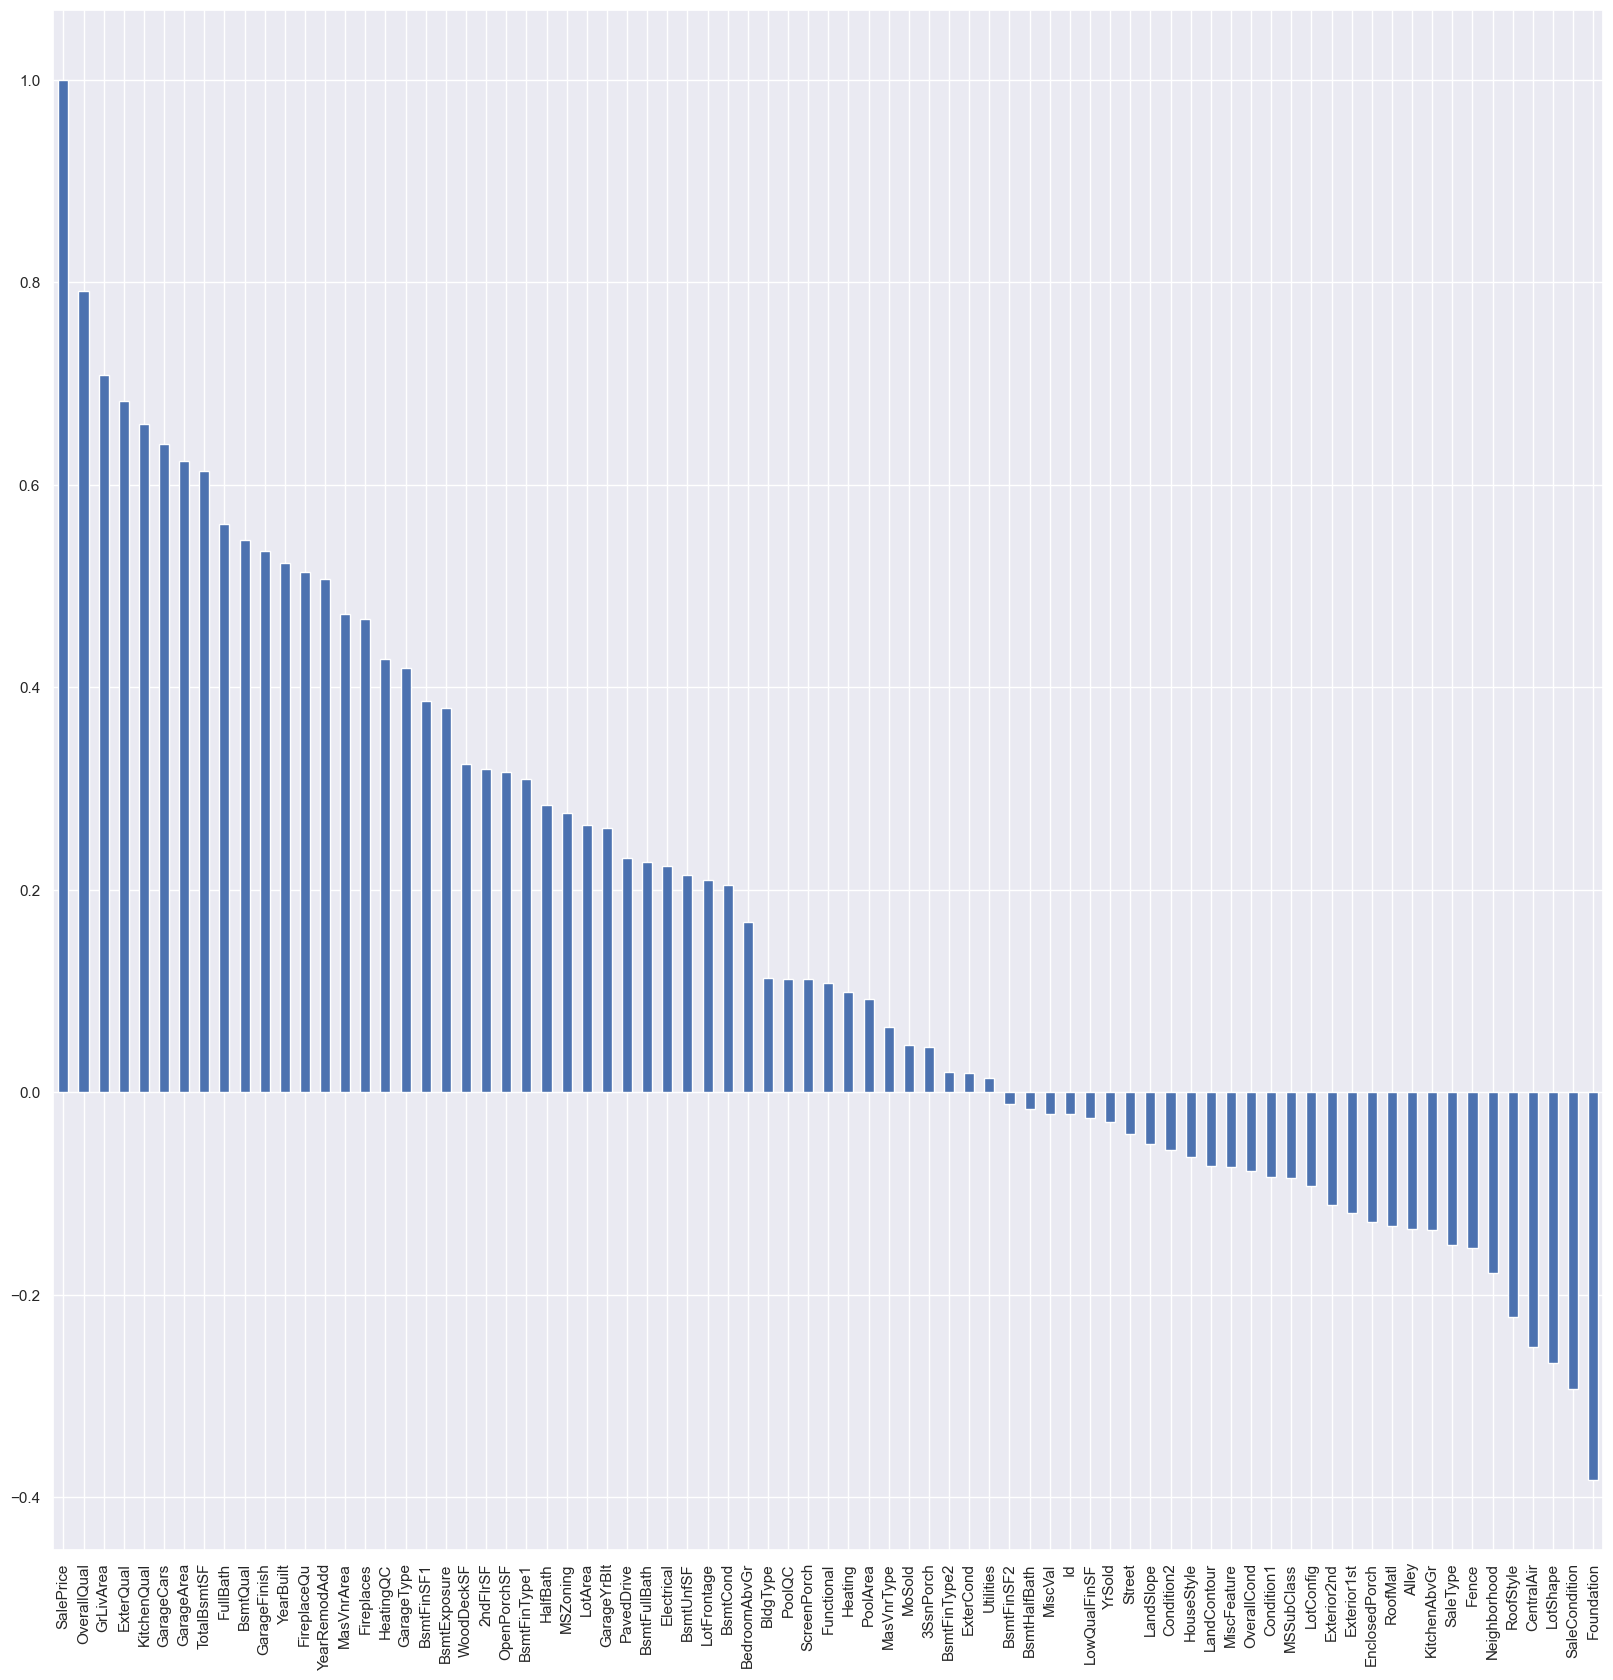

In [65]:
# Отрисовываем график коэффициентов корреляций к цене
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 20))
dataCorr.plot(kind='bar')
plt.show()

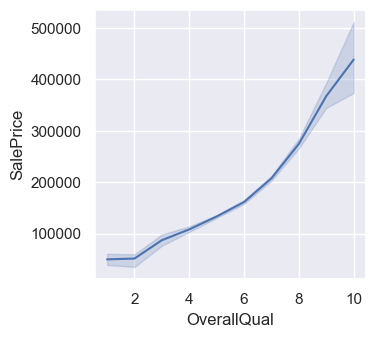

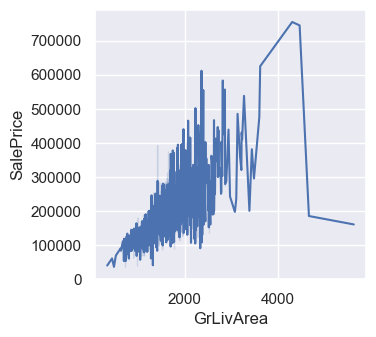

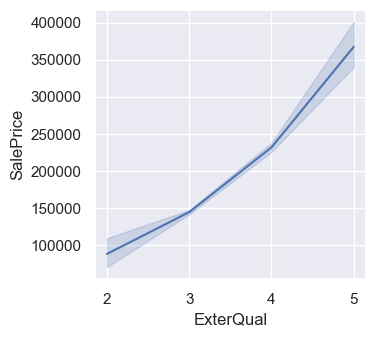

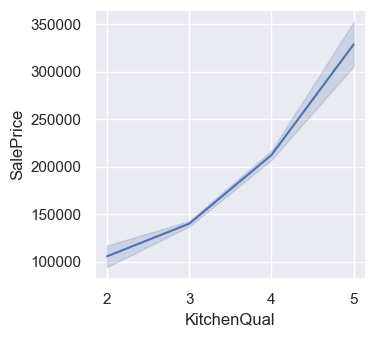

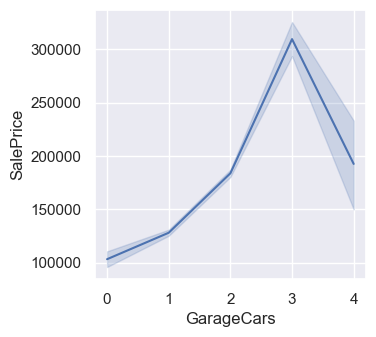

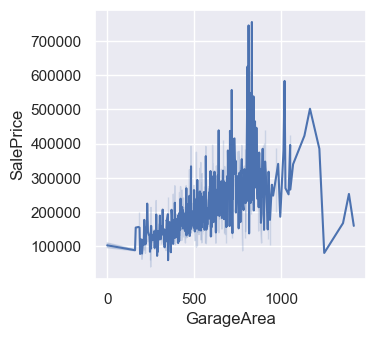

In [66]:
# Отрисовываем графики признаков
for i in range(len(chooseProperty)):
   plt.figure(figsize=(3.5, 3.5))
   sns.lineplot(data=dfTrainCopy, x=chooseProperty[i], y="SalePrice")
   plt.show()

In [67]:
print("[LOG] Count items in chooseProperty[]: " + str(len(chooseProperty)))
print(chooseProperty)

[LOG] Count items in chooseProperty[]: 6
['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'GarageArea']


In [68]:
X = dfTrainCopy[chooseProperty]
Y = dfTrainCopy.SalePrice

# Разделение на train и validation
# Обучать будем на 70% данных, проверять на 30%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [69]:
# Обучение модели и получение предсказания
lr = LinearRegression()
lr.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
prediction = lr.predict(X_test)

In [70]:
# Среднее абсолютное отклонение
mae = mean_absolute_error(y_test, prediction)
print("[LOG] mae: " + str(mae))

# Средняя квадратичная ошибка
result = rmsle(y_test, prediction)
print("[LOG] rmsle: " + str(result))

[LOG] mae: 25737.332396288733
[LOG] rmsle: 0.20259843245374173


In [71]:
# Модель обучена, теперь нужно сделать предсказание на тестовых данных
dfTest = pd.read_csv('./test.csv')
dfTestCopy = df_string_to_number(dfTest)
dfTestCopy = dfTestCopy[chooseProperty]
dfTestCopy.to_csv('result_2.csv', index=False)

In [72]:
pred = lr.predict(dfTestCopy)
dfTestCopy.drop(chooseProperty, axis=1, inplace=True)
dfTestCopy['Id'] = dfTest['Id']
dfTestCopy['SalePrice'] = pred
dfTestCopy.to_csv('result_3.csv', index=False)
print("[LOG] Done!")

[LOG] Done!
